# Python Monte Carlo simulation to forecast the value of any ticker in the next 90 days

# Background
## Monte Carlo simulations are widely used in the finance industry to forecast prices based on historical data. 

In general a Monte Carlo simulation is a way to model outcomes of random variables. Looking from a high level, this model lets a variable make lots of random choices, and repeats that simulation many times. The results are then collected and the average is taken, thus producing an estimate for the forecasted price.

## Math background
The following is the general formula on which the model is based:
$$
\displaystyle Returns_{today} = Returns_{yesterday} + Randomness
$$

Essentially, it means that the price that we observe today is inherently based on both the price that was there yesterday *and* unpredictable market shocks. Really, the only two somewhat convoluted mathematical processes we will use are the randomness term, and log returns, both of which are explained below with a high-level overview.

### GBM - Geometric Brownian Motion
In order to represent this randomness mathematically, we will use something called **Geometric Brownian Motion**. This concept originated when a botanist Robert Brown observed the erratic movement of particles in liquids and gases, and has since been used in technical fields like math and physics to model randomness.

**Brownian Motion** consists of two components: Drift and Volatility
$$
\displaystyle Drift=\mu-\frac{1}{2}\sigma^2 \\
\displaystyle Volatility = \sigma Z[Rand(0,1)]
$$
Which, in total, yields our Brownian Motion term that we will call $r$ (which stands for random):
$$
\displaystyle r= Drift + Volatility =\\
\displaystyle r = (\mu-\frac{1}{2}\sigma^2) + (\sigma Z[Rand(0,1)])
$$

Let's dive into the these equations and what they represent. 
1. Drift - this is the general direction that rates of returns have had in the past. 
    - The greek letter $\mu$ is used for the statistical mean, or average, and can be read as the expected return of the stock. 
    - The greek letter $\sigma$ represents the standard deviation, and $\sigma^2$ represents the statistical variance. This can be read as the gap between predicted returns $\mu$, and the actual returns we observed.
    - The reasoning behind subtracting the $\frac{1}{2}\sigma^2$ term is somewhat convoluted, and involves Stochastic Calculus proofs and involving Ito's Lemma (which I don't understand yet lol). 

    >*Essentially, this term corrects for the fact that returns are percentage based, and therefore affect absolute quantities more. For example, random 10% gains/losses on a \$100 investment will affect the value more than flat \$10 gains/losses. Say, you first gain 10%, and then lose 10%. Your investment's value will be \$100 -> \$110 -> \$99, which is lower than if you gained \$10 and then lost \$10. I think the main thing to understand is that this term accounts for this discrepancy.*

2. Volatility - historical volatility, which is scaled by a standard normal variable. the $Z$ term represents the $Z$ distribution that we all know and love from AMS 311. This term essentially tells us if the volatility will rise or fall, and can be loosely thought of as the volatility of the volatility.

Putting it together, we must combine these concepts with the constant $e$ to produce:
##
$$
\displaystyle S_t = S_{t-1} + GBM = \\
\displaystyle S_t = S_{t-1} + e^r = \\
\displaystyle S_t = S_{t-1} + e^{(\mu-\frac{1}{2}\sigma^2) + (\sigma Z[Rand(0,1)])}
$$
##

For the notation, $GBM$ stands for Geometric Brownian Motion, $Returns_{today} = S_t$ and $Returns_{yesterday} = S_{t-1}$. The presence of the $e$ term is also quite mysterious to me personally, but can be cautiously agreed upon because of the compounding returns we are dealing with. This, too is a more difficult math concept I've yet to understand.

## Log Returns
In finance, there are two common types of returns: **simple returns** and **log returns**.
### Simple Returns
These are the ones that we all know and love. They are easy to compute, and are intuitive:
$$
\displaystyle Returns_{simple} = \frac{Price_{today}}{Price_{yesterday}} - 1
$$
They compute the percentage change over a specified period, but they ignore the compounding effect of investing. For example, let's say that we have the following 3 closing prices for an arbitrary period:
1. \$100
2. \$50 
3. \$90
We can calculate the simple returns by doing the following: 
$$
\displaystyle \frac{50}{100} - 1 = -0.5 \\
$$
$$
\displaystyle \frac{90}{50} - 1 = 0.8
$$

This analysis produces misleading results. Looking at the returns alone, we might think that the average return is:
$$
\frac{0.8-0.5}{2}=+10.5\%
$$
But it actually is **-10%**.

### Enter Log returns:
Log returns take into account the compounding returns that we acutally observe in investment, which provides a better picture of our total cumulative results. Let's derive the formula from the usual compounding interest formula:
$$
P_t=P_0(1+r)\\
ln(P_t) = ln(P_0(1+r))\\
ln(\frac{P_t}{P_0}) = ln(1+r) = R
$$

Here, $P_t$ represents the current period's value (today), and $P_{0}$ represents the previous period's value (yesterday). $r$ represents the daily change, and $R$ is our log returns, which is the continuously compounded rate of return that we are interested in.

Coming back to our previous example, we have:
Log return for the first period = $ln(\frac{50}{100}) = -0.6931$
Log return for the second period = $ln(\frac{90}{50}) = 0.5878$

If we sum our log returns, we get $0.5878 - 0.6931 = -0.1053 = -10.53\%$

>As you can see, we got the right estimation! We produced our actual observed growth of around **-10%**. For the Monte Carlo simulation, it is crucial that we use log returns instead of simple returns to produce accurate results that account for the compounding effect.

## Now, we have the complete formula! Yaaay! We can apply this after getting historical data for $\sigma$ and $\mu$ and we will be able to run the simulation!



### Let's first download and import the necessary libraries

In [2]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
import matplotlib.animation as animation

# Set the ticker, start date, and forecast period (in days) below

In [3]:
ticker = 'SPY'
date_start = '2000-01-01'
forecast_period = 90

### Download ticker data since specified date, and clean close prices

/var/folders/kx/16s0xtg976sftl0m4b5nh2jh0000gn/T/ipykernel_19636/1456686952.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=ticker, start=date_start) # import data in the last 10 years
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

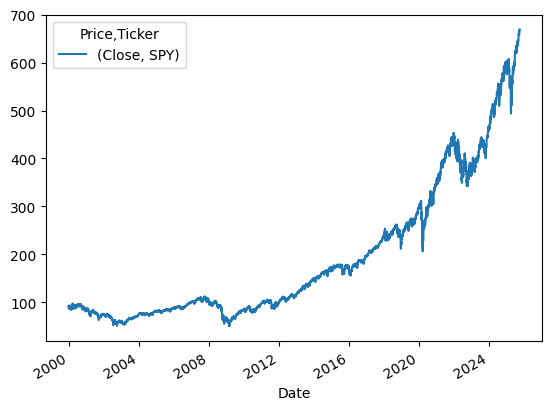

In [4]:
df = yf.download(tickers=ticker, start=date_start) # import data in the last 10 years
close_prices = df.get(['Close'])
close_prices.plot()

### Let's get our log returns and plot them

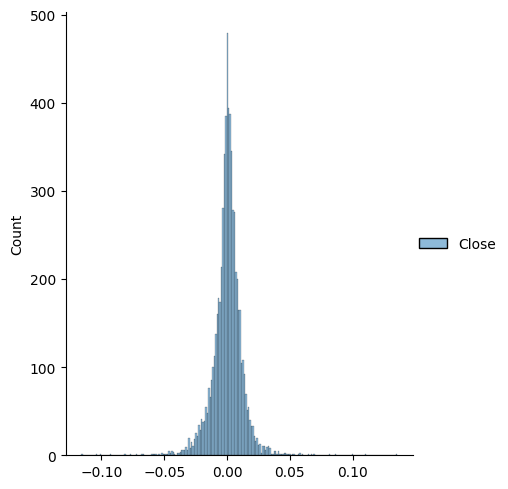

In [5]:
returns = np.log(1 + close_prices.pct_change()) # Compute log returns
plot = sns.displot(data=returns.iloc[1:])       # Let's plot them against their frequency
plot.figure.set_figwidth(5)                     # Configure the plot
plot.figure.set_figheight(5)

### Now, let's compute the average and variance of the log returns, combining them into the drift equation
$$
Drift=\mu-\frac{1}{2}\sigma^2 \\
$$

In [6]:
u = returns[1:].mean()      # Get the average
print(f"Mean: {u}%")        # Print it
var = returns[1:].var()     # Get the variance
print('var: ', var)         # Print it
drift = u - 0.5*var         # Compute the Drift
print(drift)                # Print it

Mean: Price  Ticker
Close  SPY       0.000307
dtype: float64%
var:  Price  Ticker
Close  SPY       0.00015
dtype: float64
Price  Ticker
Close  SPY       0.000231
dtype: float64


### Let's compute expected returns for each day in our forecasted period and for each trial

In [7]:
stdev = returns.std()                                           # Get the standard deviation of the returns
trials = 10000                                                  # Arbitrary number of trials, I set 10,000
Z = norm.ppf(np.random.rand(forecast_period, trials))           # Get the normal random variables
daily_returns = np.exp(drift.values + stdev.values * Z)         # Compute the e term as a matrix
print(daily_returns)                                            # Print the matrix of trials

[[0.98175168 1.02763369 1.00783129 ... 1.01125269 1.00932823 0.98516312]
 [0.98934568 0.99836562 1.02302783 ... 0.9997486  0.9968602  0.99503206]
 [0.99857786 0.98925899 0.98944926 ... 1.02013516 0.99755163 0.99878714]
 ...
 [1.00933706 1.01231466 1.0068209  ... 0.99546049 1.01467916 1.00752618]
 [0.99873405 0.99257949 0.99675043 ... 1.01753632 0.98759134 0.99554175]
 [0.99450347 1.02105545 1.02022549 ... 1.01622688 1.01390387 0.99177255]]


### We can now run the simulation and plot it!

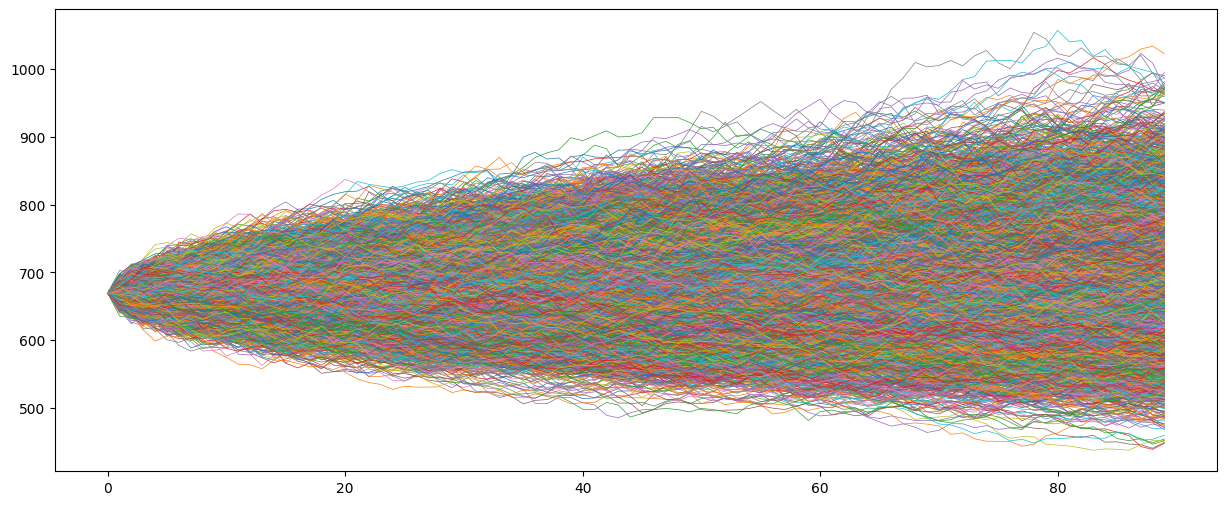

In [8]:
price_paths = np.zeros_like(daily_returns)      # Initialize a matrix of dimensions trials x forecast_period
price_paths[0] = close_prices.iloc[-1]          # Initialize all trial's start prices to the latest closing price
for t in range(1, forecast_period):                     # For each day in the forecast period
    price_paths[t] = price_paths[t-1]*daily_returns[t]  # Run the monte carlo formula

plt.figure(figsize=(15,6))                          # Plot the simulation
plt.plot(pd.DataFrame(price_paths).iloc[:,0:trials], lw=0.5)

projected_price = np.mean(price_paths[-1])


### Let's take a look at the distribution of projected prices as well. I plotted the mean in red.

Mean projected price: $687.45
This constitutes a projected return of 2.73%.


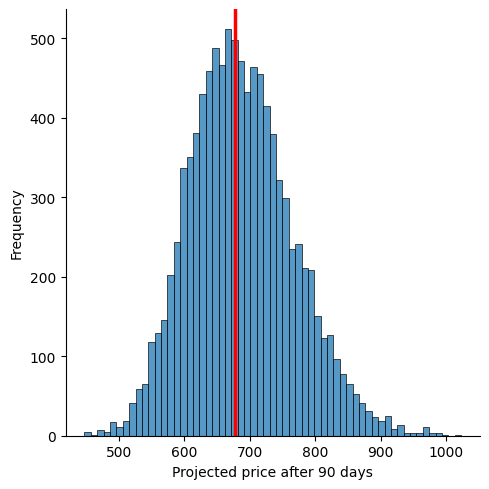

In [9]:
sns.displot(pd.DataFrame(price_paths).iloc[-1])         # Plot the prices against their frequency
plt.xlabel(f"Projected price after {forecast_period} days") # Add labels
plt.ylabel("Frequency")                                     # Add labels
plt.axvline(price_paths.mean(), color="red", label=projected_price, lw=2.5) # Add a mean line
print(f"Mean projected price: ${projected_price:.2f}")                      # Print result!
print(f"This constitutes a projected return of {100 * (projected_price / price_paths[0][0] - 1):.2f}%.")